# First Assignment
## MSc course in Artificial Intelligence



In [1]:
# Initially, we clone the course repository
!rm -rf AI_USI_MA
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 398 (delta 53), reused 99 (delta 25), pack-reused 265
Receiving objects: 100% (398/398), 13.97 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [2]:
# Let's prepare the environment by importing necessary libraries.
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import time as t
import matplotlib.pyplot as plt

################################################
# Depending on your execution environment, the way you import the required module will differ.

# If you are running this script locally on your machine, use the following import:
# from IO_manager.io_tsp import TSP_Instance_Creator
# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from solvers.constructive_algorithms import compute_length
# from solvers.local_search import TwoOpt
# from solvers.two_opt_with_candidate import twoOpt_with_cl

# However, if you are executing this notebook within Google Colab and the libraries are stored
# in a folder named 'AI_USI_MA', you should use the import statement below:
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.TSP_solver import Solver_TSP
from AI_USI_MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl




---
## Iterated Local Search (ILS) for the Traveling Salesman Problem (TSP)

The Iterated Local Search (ILS) is a metaheuristic that seeks to improve the quality of solutions by repeatedly applying a local search and introducing slight modifications (perturbations) to escape from local optima. This approach proves beneficial, especially for combinatorial problems like the Traveling Salesman Problem (TSP).

In this assignment, we will be focusing on solving the TSP using ILS for three benchmark instances:

1. **d198**: A standard instance known as 'd198.tsp' in TSP literature.
2. **pr439**: Another well-studied instance that will test the efficiency and efficacy of our ILS approach.
3. **u1060**: A relatively larger instance, serving as a comprehensive test for the scalability of our method.

Let's begin by loading and inspecting the 'd198.tsp' instance.


name: d198
nPoints: 198
best_sol: 15780.0


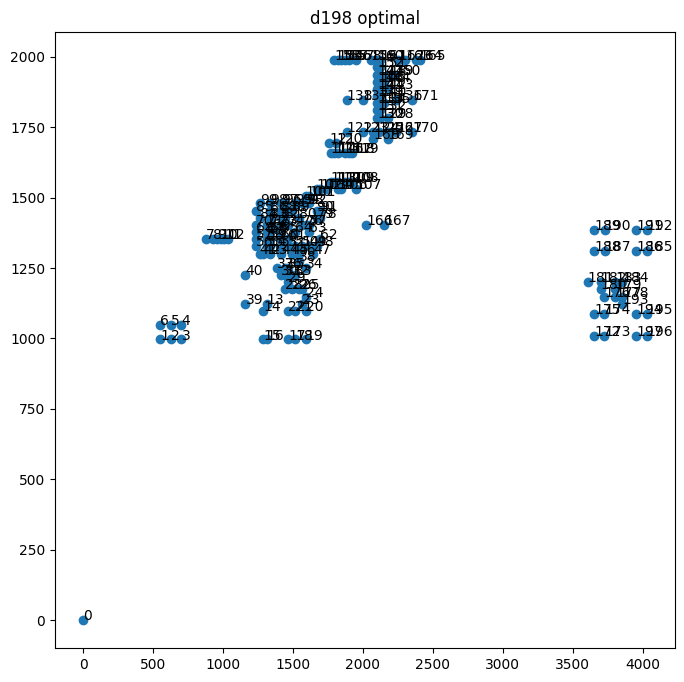

In [3]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

---
## 2-opt Algorithm for TSP

The 2-opt algorithm is a renowned local search method, predominantly utilized for refining solutions in the Traveling Salesman Problem (TSP). At its core, the algorithm takes a route and systematically swaps pairs of cities to ascertain if the change results in a shorter tour.

In this notebook, we furnish a black-box version of the 2-opt. For those embarking on its usage for the first time, we suggest revisiting our ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI_USI_MA/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa). It's paramount that any meta-heuristic, including 2-opt, complies with the specific input and output conventions laid out in the primary notebook.

For a tangible example, glance over the **naive_heuristic**. Within, the `TwoOpt.local_search` method is invoked to iteratively enhance the TSP solution.

Two instrumental aspects to note in our design are:
1. The `yield` statement: Serving as a generator, it permits the algorithm to produce solutions in phases, thus allowing exploration of a plethora of potential solutions without exhaustive execution.
2. The `ending_cond` (Ending Condition): Crafted to ensure the TSP Solver either ceases after 3 minutes or concludes when the local search achieves an optimum state via the heuristic.

---


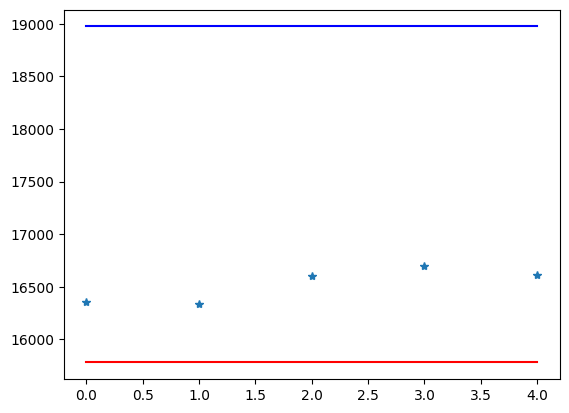

best gap with NN 20.25% on 1 trial,
with a total time of 0.007 seconds

best gap with random + 2opt 3.52% on 5 trials,
with a total time of 8.21 seconds


In [4]:
def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [5]:
import random

class DoubleBridge:
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    # Create a new solution by rearranging the segments
    new_solution = (solution[0:a] + solution[d:] + solution[b:c] + solution[a:b] + solution[c:d])

    # Calculate the previous and new costs
    previous_cost = compute_length(solution, matrix)
    new_cost = compute_length(new_solution, matrix)

    # Calculate the cost difference
    difference = previous_cost - new_cost
    return difference

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    # Create a copy of the solution
    lendiv = list(solution)
    partition = int(len(lendiv) // 4)

    a = random.randint(0, partition)
    b = a + 1 + random.randint(0, partition)
    c = b + 1 + random.randint(0, partition)
    d = c + 1 + random.randint(0, partition)

    # Create a new solution by rearranging the segments
    curr = []
    curr.extend(solution[a:b])
    curr.extend(solution[d:])
    curr.extend(solution[0:a])
    curr.extend(solution[c:d])
    curr.extend(solution[b:c])

    solution = curr

    # Calculate the new cost
    actual_cost = compute_length(solution, matrix)

    return solution, actual_cost

In this part of the code, I defined two functions: "different cost" and "perturbation solution." In the "different cost" function, I processed various parameters, including the matrix. Based on the information contained in the "compute length" function, I computed the new length and cost. Additionally, I calculated the difference between the new and previous costs and determined if the new solution was better. In the "perturbation solution" function, I received the solution and actual cost, converting the solution to a list. Considering these points, I rearranged them to create a new solution. I then utilized the "compute length" function to calculate the cost of the new solution.

In [6]:
# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 6.149850545481624
[0, 1, 2, 3, 8, 9, 10, 11, 5, 6, 7, 4] 6.835398500459421


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw earlier in class.

To boost the time performances please use the cython class **two_opt_with_candidate**.

In [7]:
import math

def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    if ending_cond == True:
      break
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    """
    #  in case you want to use twoOpt_with_cl
    cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    """
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:

      # implement perturbation
      new_solution, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      ls_calls += 1
      cost_sol_better.append(new_cost)

      # implement acceptance criterion
      if new_cost < best_cost:
        best_sol = new_solution
        best_cost = new_cost

      yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:

      # implement perturbation
      new_solution, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      ls_calls += 1
      cost_sol_RW.append(new_cost)

      # implement acceptance criterion
      if new_cost < best_cost:
        best_sol = new_solution
        best_cost = new_cost

      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    return

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1
    while True:

      # implement perturbation
      temp = (len(solution))*2
      new_solution, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      ls_calls += 1
      cost_sol_LSMC.append(new_cost)

      # implement acceptance criterion
      delta_cost = new_cost - best_cost
      if delta_cost < 0 or random.random() < math.exp(-delta_cost / temp):
          best_sol = new_solution
          best_cost = new_cost

      yield best_sol, best_cost, ls_calls, False

For the iterated local search section first I implemented the ILS with three different acceptance criterion. I did it in three ways : better,random walk and Markov chain.

**ILS_Better**:

In this code segment, I performed the "better" method in an iterative process. In each iteration, I conducted perturbation and local search operations, and incremented the count of local search calls. Then stored the new cost in the "cost_sol_better" list. I applied an acceptance criterion by comparing the new cost with the best cost. If the new cost is better, then update the current solution and cost. The process continues to iterate, yielding the best solution, best cost, local search calls, and a "False" flag to indicate the ongoing execution of the "better" method.

**ILS_RW**:

Like last part it will call Local search and save the best solution and best cost. In each iteration, perturbation and local search are carried out on the current solution, with the local search count being updated. The new cost is recorded in the "cost_sol_RW" list. An acceptance criterion is then applied, checking if the new cost is lower than the current best cost. If it is, the current solution is updated as the best. These steps are repeated in a continuous loop, with the best solution, best cost, local search calls, and a "False" flag being yielded to indicate ongoing RW iterations.

**ILS_LSMC**:

In LSMC, I considered two critical parameters: temperature and the value of how much our local minimum worsens. I called Local search and saved the best solution and best cost. I used perturbation, followed by another local search (similar to the previous steps). However, this time, the acceptance criterion was different, relying on the two mentioned parameters. I utilized the acceptance criterion function to obtain the best solution and best cost and implemented a specific factor for the temperature. Considering the exponential equation ((best cost - new cost) / Temperature), I multiplied the temperature by the mentioned factor in each iteration, leading to a decreasing temperature. If the new cost was better than the best cost, I updated the best cost with the new cost and accepted it. If not, I compared the temperature (temp) to the threshold defined earlier. If it was accepted to continue, it proceeded; otherwise, it returned the solution.

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task!

In [14]:
import math

seeds= [0, 123, 333]
time_to_solve = 180 # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

names_instances = ["d198.tsp"] #, "pr439.tsp", "u1060.tsp"

initializers = ["random"]
init_functions = [Random_Initializer.random_method]

improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))

      start_time = t()  # Start measuring time
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        while True:
        # Run the solver until the time limit is reached
          if t() - start_time > time_to_solve:
            break
          solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

tour length  \
problem  optimal length method                                            seed                
d198.tsp 15780.0        initialized with random, improved with ILS-better 0         16595.0   
                        initialized with random, improved with ILS-RW     0         16512.0   
                        initialized with random, improved with ILS-LSMC   0         57609.0   
                        initialized with random, improved with ILS-better 123       16420.0   
                        initialized with random, improved with ILS-RW     123       16420.0   
                        initialized with random, improved with ILS-LSMC   123       67002.0   
                        initialized with random, improved with ILS-better 333       16617.0   
                        initialized with random, improved with ILS-RW     333       16617.0   
                        initialized with random, improved with ILS-LSMC   333       60195.0   

                                                                                   gap  \
problem  optimal length method                                            seed           
d198.tsp 15780.0        initialized with random, improved with ILS-better 0       5.16   
                        initialized with random, improved with ILS-RW     0       4.64   
                        initialized with random, improved with ILS-LSMC   0     265.08   
                        initialized with random, improved with ILS-better 123     4.06   
                        initialized with random, improved with ILS-RW     123     4.06   
                        initialized with random, improved with ILS-LSMC   123   324.60   
                        initialized with random, improved with ILS-better 333     5.30   
                        initialized with random, improved with ILS-RW     333     5.30   
                        initialized with random, improved with ILS-LSMC   333   281.46   

                                                                                time to solve  \
problem  optimal length method                                            seed                  
d198.tsp 15780.0        initialized with random, improved with ILS-better 0           180.032   
                        initialized with random, improved with ILS-RW     0           180.030   
                        initialized with random, improved with ILS-LSMC   0           180.024   
                        initialized with random, improved with ILS-better 123         180.013   
                        initialized with random, improved with ILS-RW     123         180.000   
                        initialized with random, improved with ILS-LSMC   123         180.030   
                        initialized with random, improved with ILS-better 333         180.010   
                        initialized with random, improved with ILS-RW     333         180.008   
                        initialized with random, improved with ILS-LSMC   333         180.041   

                                                                                calls Local Search  
problem  optimal length method                                            seed                      
d198.tsp 15780.0        initialized with random, improved with ILS-better 0                   3683  
                        initialized with random, improved with ILS-RW     0                   3707  
                        initialized with random, improved with ILS-LSMC   0                   3680  
                        initialized with random, improved with ILS-better 123                 3712  
                        initialized with random, improved with ILS-RW     123                 3701  
                        initialized with random, improved with ILS-LSMC   123                 3669  
                        initialized with random, improved with ILS-better 333                 3717  
                        initialized with random, improved with ILS

The tables generated from the code provide insights into the quality of solutions for one for three different instances (d198). These tables include information about tour length, gap, time to solve, and the number of local search calls. It is evident that the best solution for each instance is characterized by the lowest gap and the shortest tour length.

In the table, we can examine the performance of three different algorithms— **Better**, **RW**, and **LSMC** three distinct seeds. This results in a total of nine rows in each table. To identify the best solution, we prioritize solutions with the smallest gap and the shortest tour length. This approach allows us to assess the effectiveness of different acceptance criteria for each seed and make informed decisions about the optimal solutions for these instances.

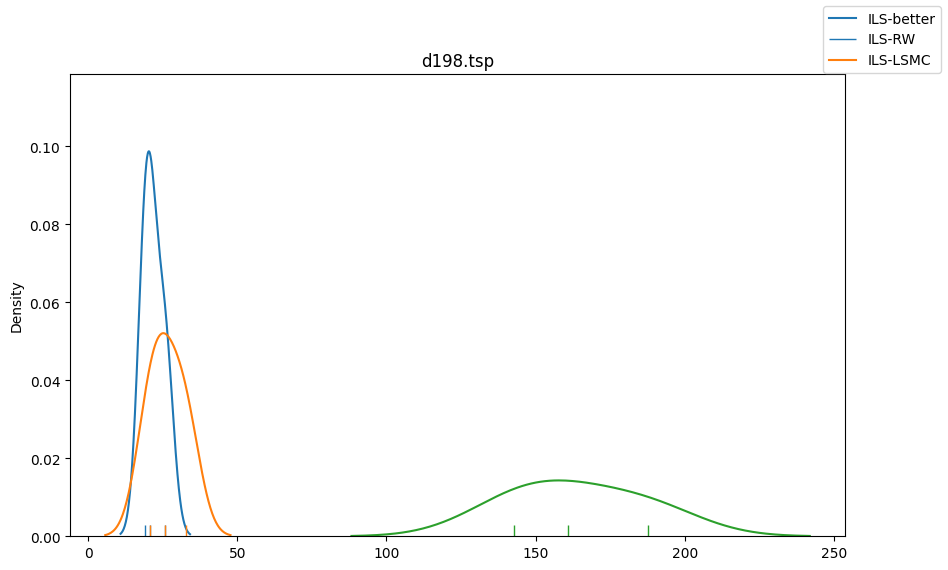

In [15]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data = pd.DataFrame.from_dict(samples[instance][improve], orient='index').transpose()
      data_avg = data.mean(axis = 0, skipna = True)
      sns.distplot(data_avg, rug=True, hist=False)

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()